# 遮挡可解释性分析-自己训练的水果分类模型

用小滑块，滑动遮挡输入图像上的不同区域，观察哪些区域被遮挡后会显著影响模型的分类决策。

更改滑块尺寸、滑动步长，对比效果。

同济子豪兄 https://space.bilibili.com/1900783

代码运行云GPU平台：https://featurize.cn/?s=d7ce99f842414bfcaea5662a97581bd1

2022-8-19

## 导入工具包

In [1]:
import os
import json
import numpy as np
import pandas as pd

from PIL import Image

import torch
import torch.nn.functional as F
import torchvision
from torchvision import models
from torchvision import transforms

# from captum.attr import IntegratedGradients
# from captum.attr import GradientShap
from captum.attr import Occlusion
# from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


## 载入自己训练好的模型

In [2]:
model = torch.load('checkpoints/fruit30_pytorch_20220814.pth')
model = model.eval().to(device)

## 载入类别

In [3]:
idx_to_labels = np.load('idx_to_labels.npy', allow_pickle=True).item()

In [4]:
idx_to_labels

{0: '哈密瓜',
 1: '圣女果',
 2: '山竹',
 3: '杨梅',
 4: '柚子',
 5: '柠檬',
 6: '桂圆',
 7: '梨',
 8: '椰子',
 9: '榴莲',
 10: '火龙果',
 11: '猕猴桃',
 12: '石榴',
 13: '砂糖橘',
 14: '胡萝卜',
 15: '脐橙',
 16: '芒果',
 17: '苦瓜',
 18: '苹果-红',
 19: '苹果-青',
 20: '草莓',
 21: '荔枝',
 22: '菠萝',
 23: '葡萄-白',
 24: '葡萄-红',
 25: '西瓜',
 26: '西红柿',
 27: '车厘子',
 28: '香蕉',
 29: '黄瓜'}

## 图像预处理

In [5]:
from torchvision import transforms

# 缩放、裁剪、转 Tensor、归一化
transform_A = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),          
    transforms.ToTensor()         
])

transform_B = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

## 载入测试图像

In [157]:
# img_path = 'test_img/test_orange_2.jpg'
# img_path = 'test_img/test_石榴.jpg'
# img_path = 'test_img/test_kiwi.jpg'
# img_path = 'test_img/test_lemon.jpg'
# img_path = 'test_img/test_bananan.jpg'
img_path = 'test_img/test_草莓.jpg'

In [158]:
img_pil = Image.open(img_path)

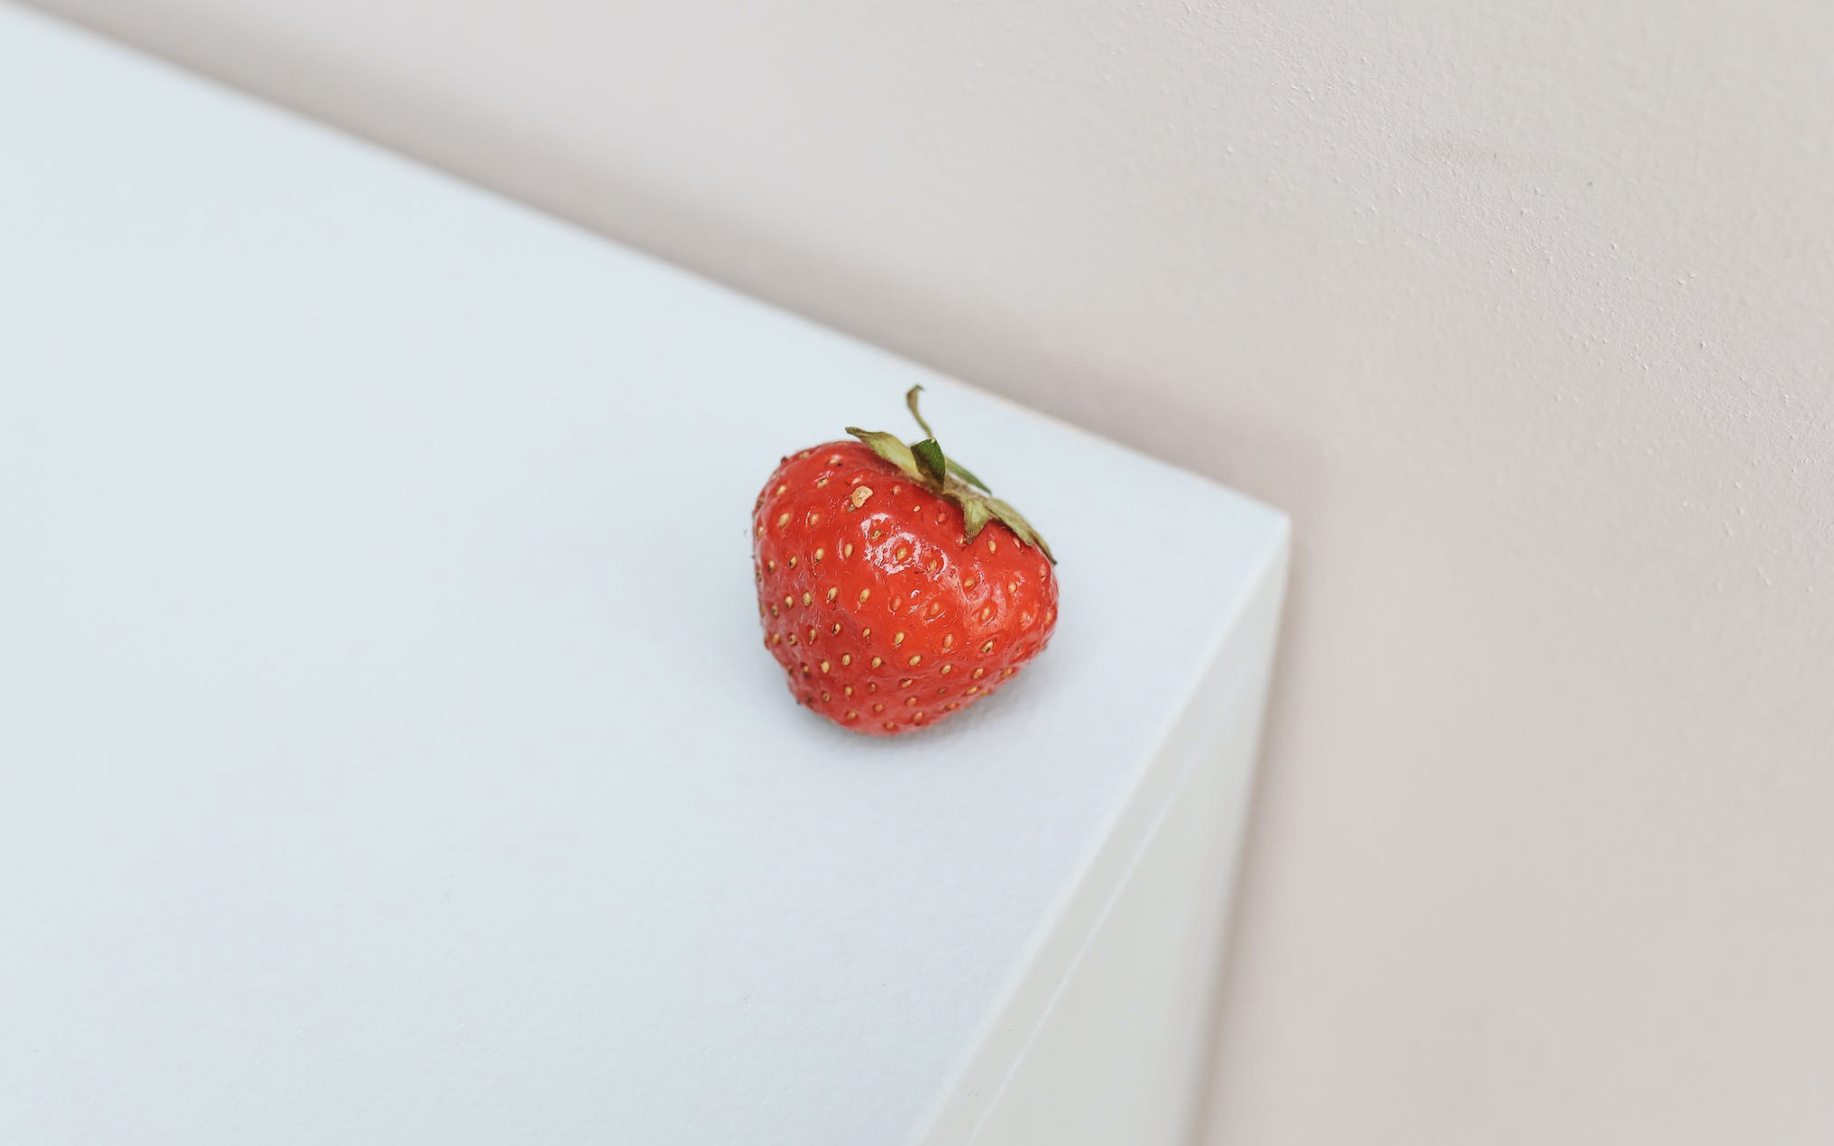

In [159]:
img_pil

## 预处理

In [160]:
# 缩放、裁剪
rc_img = transform_A(img_pil)

In [161]:
rc_img.shape

torch.Size([3, 224, 224])

In [162]:
# 调整数据维度
rc_img_norm = np.transpose(rc_img.squeeze().cpu().detach().numpy(), (1,2,0))

In [163]:
rc_img_norm.shape

(224, 224, 3)

In [164]:
# 色彩归一化
input_tensor = transform_B(rc_img).unsqueeze(0).to(device)

In [165]:
input_tensor.shape

torch.Size([1, 3, 224, 224])

## 前向预测

In [166]:
pred_logits = model(input_tensor)
pred_softmax = F.softmax(pred_logits, dim=1) # 对 logit 分数做 softmax 运算

In [167]:
pred_softmax.shape

torch.Size([1, 30])

In [168]:
pred_conf, pred_id = torch.topk(pred_softmax, 1)
pred_conf = pred_conf.detach().cpu().numpy().squeeze().item()
pred_id = pred_id.detach().cpu().numpy().squeeze().item()

In [169]:
pred_id

20

In [170]:
pred_conf

0.9960836172103882

In [171]:
pred_label = idx_to_labels[pred_id]

In [172]:
pred_label

'草莓'

In [173]:
print('预测类别的ID {} 名称 {} 置信度 {:.2f}'.format(pred_id, pred_label, pred_conf))

预测类别的ID 20 名称 草莓 置信度 1.00


## 遮挡可解释性分析

在输入图像上，用遮挡滑块，滑动遮挡不同区域，探索哪些区域被遮挡后会显著影响模型的分类决策。

提示：因为每次遮挡都需要分别单独预测，因此代码运行可能需要较长时间。

In [174]:
occlusion = Occlusion(model)

### 中等遮挡滑块

In [175]:
# 获得输入图像每个像素的 occ 值
attributions_occ = occlusion.attribute(input_tensor,
                                       strides = (3, 8, 8), # 遮挡滑动移动步长
                                       target=pred_id, # 目标类别
                                       sliding_window_shapes=(3, 15, 15), # 遮挡滑块尺寸
                                       baselines=0) # 被遮挡滑块覆盖的像素值

In [176]:
attributions_occ.shape

torch.Size([1, 3, 224, 224])

In [177]:
# 转为 224 x 224 x 3的数据维度
attributions_occ_norm = np.transpose(attributions_occ.detach().cpu().squeeze().numpy(), (1,2,0))

In [178]:
attributions_occ_norm.shape

(224, 224, 3)

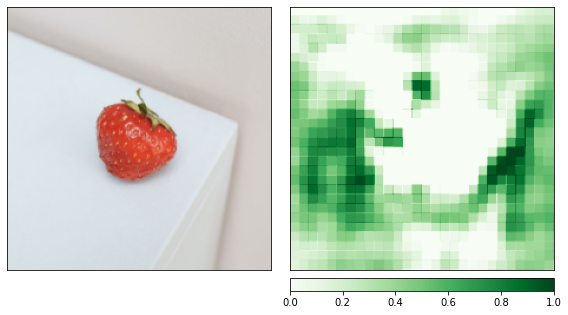

In [179]:
viz.visualize_image_attr_multiple(attributions_occ_norm, # 224 224 3
                                  rc_img_norm,           # 224 224 3
                                  ["original_image", "heat_map"],
                                  ["all", "positive"],
                                  show_colorbar=True,
                                  outlier_perc=2)
plt.show()

### 大遮挡滑块

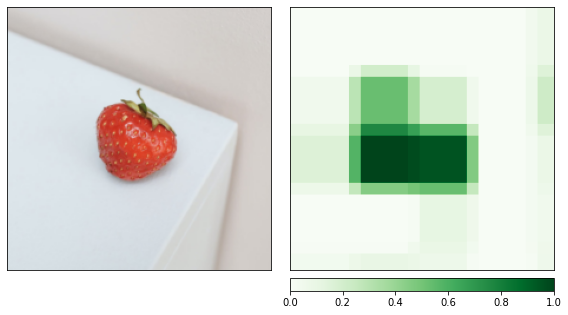

In [180]:
# 更改遮挡滑块的尺寸
attributions_occ = occlusion.attribute(input_tensor,
                                       strides = (3, 50, 50), # 遮挡滑动移动步长
                                       target=pred_id, # 目标类别
                                       sliding_window_shapes=(3, 60, 60), # 遮挡滑块尺寸
                                       baselines=0)

# 转为 224 x 224 x 3的数据维度
attributions_occ_norm = np.transpose(attributions_occ.detach().cpu().squeeze().numpy(), (1,2,0))

viz.visualize_image_attr_multiple(attributions_occ_norm, # 224 224 3
                                  rc_img_norm,           # 224 224 3
                                  ["original_image", "heat_map"],
                                  ["all", "positive"],
                                  show_colorbar=True,
                                  outlier_perc=2)
plt.show()

### 小遮挡滑块（运行时间较长，2分钟左右）

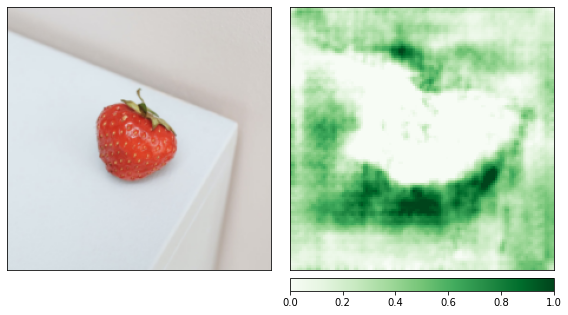

In [181]:
# 更改遮挡滑块的尺寸
attributions_occ = occlusion.attribute(input_tensor,
                                       strides = (3, 2, 2), # 遮挡滑动移动步长
                                       target=pred_id, # 目标类别
                                       sliding_window_shapes=(3, 4, 4), # 遮挡滑块尺寸
                                       baselines=0)

# 转为 224 x 224 x 3的数据维度
attributions_occ_norm = np.transpose(attributions_occ.detach().cpu().squeeze().numpy(), (1,2,0))

viz.visualize_image_attr_multiple(attributions_occ_norm, # 224 224 3
                                  rc_img_norm,           # 224 224 3
                                  ["original_image", "heat_map"],
                                  ["all", "positive"],
                                  show_colorbar=True,
                                  outlier_perc=2)
plt.show()